## SGD for FM
目标函数
![](img_fm/1.png)
加入正则项，防止过拟合
![](img_fm/2.png)
Algorithm for SGD
![](img_fm/3.png)
![](img_fm/4.png)

### load data

In [3]:
import numpy as np
from sklearn.feature_extraction import DictVectorizer
import math
import matplotlib.pyplot as plt
# Read in data
def loadData(filename,path="ml-100k/"):
    data = []
    y = []
    users=set()
    items=set()
    with open(path+filename) as f:
        for line in f:
            (user,movieid,rating,ts)=line.split('\t')
            data.append({ "user_id": str(user), "movie_id": str(movieid)})
            y.append(float(rating))
            users.add(user)
            items.add(movieid)

    return (data, np.array(y), users, items)

### 使用SGD训练FM

In [368]:
class FM_SGD():
    
    def __init__(self,
                iter_num,
                learning_rate,
                factors_num,
                reg,
                verbose = True):
        
        # 迭代次数
        self.iter_num = iter_num
        
        #学习速率
        self.learning_rate = learning_rate
        
        # 分解器feature个数
        self.factors_num = factors_num
        
        # lambda
        self.reg = reg
        
        # 输出执行信息
        self.verbose = verbose
        
        # global bias
        self.w0 = 0;
        
        # feature bias
        self.W = 0;
        
        # feature
        self.V = 0;
        
        # 训练过程中的mse
        self.mse = []
        
        # target y的最大值与最小值，for prune
        self.y_max = 0.0;
        self.y_min = 0.0;
        
        
    def train(self, X_, y_):
        
        (n,p) = X_.shape
        
        self.mse = []
        
        # global bias
        self.w0 = sum(np.random.rand(1))  # bias
        
        # feature bias
        self.W = 1e-5*np.random.rand(1,p)
        
        # feature
        self.V = 1e-5*np.random.rand(p,self.factors_num)
        
        self.y_max = np.max(y_)
        self.y_min = np.min(y_)
        
        for j in xrange(self.iter_num):
            
            loss_sgd = []

            # shuffle
            reidx = np.random.permutation(n)
            X_train = X_[reidx,:]
            y_train = y_[reidx]

            

            for i in xrange(n):

                if self.verbose and i%1000 ==0:
                    print 'prossing ' + str(i) + 'th sample...'

                X = X_train[i,:]
                y = y_train[i]

                # too slow
            #     y_predict = (w0 + W*X.T + ((X.T*X).multiply((np.triu(V.dot(V.T),1)))).sum().sum())[0,0]

                tmp = np.sum(X.T.multiply(self.V),axis=0)
                factor_part = (np.sum(np.multiply(tmp,tmp)) - np.sum((X.T.multiply(X.T)).multiply(np.multiply(self.V,self.V))))/2
                y_predict = self.w0 + np.sum(self.W*X.T) + factor_part
                
#                 print y_predict

                # prune
                if y_predict < self.y_min:
                    y_predict = self.y_min

                if y_predict > self.y_max:
                    y_predict = self.y_max

                diff = y_predict-y
                loss_sgd.append(math.pow(diff,2))

                # update mse
                self.mse.append(sum(loss_sgd)/len(loss_sgd))

                # update w0
                self.w0 = self.w0 - learning_rate*2*diff * (1)
                
                # update W
                self.W = self.W - learning_rate*2*diff * (X)
                
                # update V
                self.V = self.V - learning_rate * 2*diff* (X.T.multiply((np.tile(X*self.V,(p,1)) - X.T.multiply(self.V))))

#     def predict(self, X_test, y_test):
        
    

In [369]:
(train_data, y_train, train_users, train_items) = loadData("ua.base")
(test_data, y_test, test_users, test_items) = loadData("ua.test")

v = DictVectorizer()
X_train = v.fit_transform(train_data)
X_test = v.transform(test_data)
fm_sgd = FM_SGD(iter_num=1,
               learning_rate=0.01,
               factors_num=10,
               reg=0.1)
fm_sgd.train(X_train,y_train)

prossing 0th sample...
0.00795141063281
0.0679575357322
0.127949673853
0.147953826295
0.20795694874
0.227954006726
0.287951521607
0.367953077144
0.427952769565
0.467955883454
0.547956402553
0.587952624783
0.66795935395
0.827953290715
0.807958883035
0.767951716182
0.887953277474
0.867949160568
0.927957328209
1.00795594132
1.06778984717
1.08643311865
1.12470841162
1.20221831514
1.27817276485
1.31261622764
1.36635587592
1.41903094273
1.49064769478
1.54083880233
1.59002431538
1.6982246213
1.6842527504
1.73057302039
1.84227335997
1.83911767466
1.9621740254
1.94309232805
2.00737691443
2.00407583736
2.00400173263
2.06391514198
2.16263435724
2.13938778554
2.17659553482
2.21178834839
2.20882681101
2.24464345225
2.27975397842
2.31416430722
2.34788240373
2.40092291229
2.43290331937
2.4642469042
2.47495183013
2.46545381213
2.51615510469
2.56582635768
2.59451420853
2.58262565182
2.59908628756
2.6189820921
2.66661147629
2.7738747087
2.70977405794
2.70359835505
2.70953247536
2.69534640147
2.661431441

KeyboardInterrupt: 

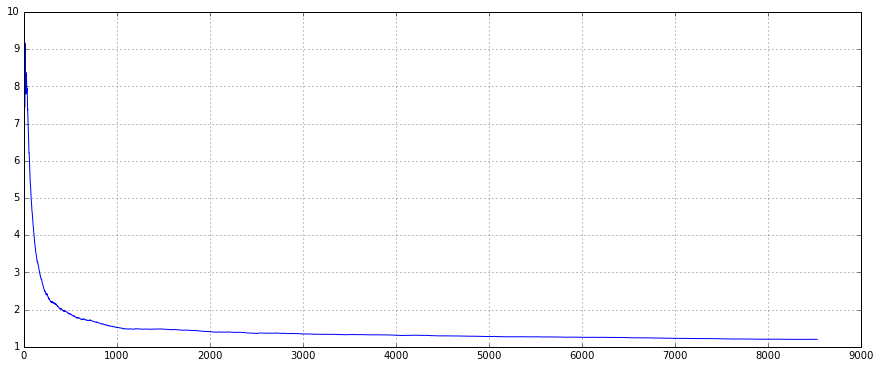

In [370]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15,6
plt.grid(True)
plt.plot(fm_sgd.mse)

> numpy's dot function does not have native support for handling sparse matrices. What is happening is numpy thinks of the sparse matrix C as a python object

In [348]:
fm_sgd.W

matrix([[ 30.26000552,   6.28000868,  36.76000264, ...,   4.34000215,
           1.26000601,   9.02000287]])

In [350]:
fm_sgd.mse

[9.0,
 12.5,
 16.666666666666668,
 14.75,
 15.0,
 16.666666666666668,
 15.571428571428571,
 15.625,
 14.88888888888889,
 13.5,
 13.090909090909092,
 12.75,
 11.846153846153847,
 12.142857142857142,
 13.0,
 13.1875,
 13.352941176470589,
 13.11111111111111,
 12.894736842105264,
 12.45,
 12.047619047619047,
 11.681818181818182,
 11.869565217391305,
 12.041666666666666,
 11.92,
 12.076923076923077,
 11.962962962962964,
 12.107142857142858,
 11.827586206896552,
 12.266666666666667,
 12.67741935483871,
 12.78125,
 12.666666666666666,
 12.323529411764707,
 12.085714285714285,
 12.444444444444445,
 12.783783783783784,
 13.105263157894736,
 13.0,
 13.075,
 13.365853658536585,
 13.261904761904763,
 13.162790697674419,
 13.431818181818182,
 13.488888888888889,
 13.73913043478261,
 13.787234042553191,
 14.020833333333334,
 14.061224489795919,
 13.96,
 13.862745098039216,
 13.903846153846153,
 13.81132075471698,
 14.018518518518519,
 14.054545454545455,
 14.089285714285714,
 13.912280701754385,
 13